### To-Do
*   Delete dates that spill over to the previous year (Eg: for the 1st weekly expiry of Jan 2020, its dates spill over to 2019) ***Done***



In [44]:
import pandas as pd
import numpy as np

In [64]:
# initialising google drive api

from __future__ import print_function
import pickle
import os.path
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request

# If modifying these scopes, delete the file token.pickle.
SCOPES = ['https://www.googleapis.com/auth/drive.readonly']

"""Shows basic usage of the Drive v3 API.
Prints the names and ids of the first 10 files the user has access to.
"""
creds = None
# The file token.pickle stores the user's access and refresh tokens, and is
# created automatically when the authorization flow completes for the first
# time.
if os.path.exists('token.pickle'):
    with open('token.pickle', 'rb') as token:
        creds = pickle.load(token)
# If there are no (valid) credentials available, let the user log in.
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file(
            'credentials.json', SCOPES)
        creds = flow.run_local_server(port=0)
    # Save the credentials for the next run
    with open('token.pickle', 'wb') as token:
        pickle.dump(creds, token)

drive_service = build('drive', 'v3', credentials=creds)

# Call the Drive v3 API
results = drive_service.files().list(
    pageSize=10, fields="nextPageToken, files(id, name)").execute()
items = results.get('files', [])

if not items:
    print('No files found.')
else:
    print('Files found. Google Drive API instance enabled.')
    # for item in items:
    #     print(u'{0} ({1})'.format(item['name'], item['id']))

Files found. Google Drive API instance enabled.


In [46]:
FILE_ID = None
QUERY = "name = 'BANKNIFTYWK16500PE.csv' and mimeType = 'text/csv'"

def getFileList(service,query=None):
  """Search for file and retrieve file id
  Args:
    service: Google Drive API service instance
  Returns:
    file id
  """
  response = []
  page_token = None
  while True:
    param = {}
    param['q'] = query
    if page_token:
      param['pageToken'] = page_token
    files = service.files().list(**param).execute()
    response.extend(files['files'])
    page_token = files.get('nextPageToken')
    if not page_token:
      break
  return response

In [47]:
import io
from googleapiclient.http import MediaIoBaseDownload

def downloadFromDrive(service,fileid):
  """Download file from Drive
  Args:
    service: Google Drive API service instance
    fileid: file id of file to be downloaded
  Returns:
    object of io class containing downloaded file content as bytes
  """
  request = service.files().get_media(fileId=fileid)
  downloaded = io.BytesIO()
  downloader = MediaIoBaseDownload(downloaded, request)
  done = False
  while done is False:
      status, done = downloader.next_chunk()
      print("Download %d%%." % int(status.progress() * 100))
  return downloaded

# **Straddle**

In [63]:
# fetching stock price (for BANKNIFTY)
TICKER = 'BANKNIFTY'
TICKER_COLUMNS = ['Ticker','Date','Time','Open','High','Low','Close','Volume','OpenInterest']
ticker_data = pd.DataFrame()

ticker_query = "name = '%s' and mimeType = 'application/vnd.google-apps.folder'" % TICKER
TICKER_LIST = getFileList(drive_service,ticker_query)
for file in TICKER_LIST:
  FILE_ID = file['id']

filesinfolder_query = "'%s' in parents" % FILE_ID
FILE_LIST = getFileList(drive_service,filesinfolder_query)
for file in FILE_LIST:
  downloaded = downloadFromDrive(drive_service,file['id'])
  buffer_contents = downloaded.getvalue().decode(encoding='utf-8')
  data = io.StringIO(buffer_contents)
  ticker_data = ticker_data.append(pd.read_csv(data,sep=",",names=TICKER_COLUMNS,index_col=False),ignore_index=True)

ticker_data['DateTime'] = ""

Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.


In [49]:
# converting date, time values to the datetime dtype
for index in ticker_data.index:
  counter = 0
  ticker_year, ticker_month, ticker_day = '','',''
  for char in str(ticker_data['Date'][index]):
    counter += 1
    if counter<=4:
      ticker_year += char
    elif counter>4 and counter <=6:
      ticker_month += char
    else:
      ticker_day += char
  ticker_data['DateTime'][index] = pd.to_datetime(ticker_year+' '+ticker_month+' '+ticker_day+' '+ticker_data['Time'][index])

# ticker_data = ticker_data.set_index('DateTime')
ticker_data = ticker_data.drop(['Date','Time'],axis=1)
%time ticker_data.head()

Wall time: 977 µs


,Ticker,Open,High,Low,Close,Volume,OpenInterest,DateTime
0,BANKNIFTY,19122.40,19122.40,19122.40,19122.40,0,0,2020-04-01 09:08:00
1,BANKNIFTY,19149.60,19154.75,18889.80,18958.40,0,0,2020-04-01 09:16:00
2,BANKNIFTY,18953.80,18958.45,18824.75,18876.45,0,0,2020-04-01 09:17:00
3,BANKNIFTY,18878.05,18919.15,18864.00,18864.00,0,0,2020-04-01 09:18:00
4,BANKNIFTY,18867.75,18867.75,18813.75,18856.05,0,0,2020-04-01 09:19:00


In [62]:
# fetching folder for year (eg:2020)
YEAR_START = 2020
QUERY = "name = '%d' and mimeType = 'application/vnd.google-apps.folder'" % YEAR_START
FILE_LIST = getFileList(drive_service,QUERY)

for files in FILE_LIST:
  FILE_ID = files['id']

# fetching files in year folder
filesinfolder_query = "'%s' in parents" % FILE_ID
FILE_LIST = getFileList(drive_service,filesinfolder_query)
# print(FILE_LIST)

In [51]:
# fetching all dates when Straddle to be executed
from datetime import timedelta

dateinfile = []
allDaysForOptions = [] #to store calculable days for each weekly expiry
for file in FILE_LIST:
  dateinfile = file['name'].split(maxsplit=1)[-1]
  dateinfile += str(YEAR_START)
  rawdate = pd.to_datetime(dateinfile)
  dayCounter = rawdate.dayofweek + 1
  optionDaysForWeek = []
  insertCounter = 0
  while len(optionDaysForWeek) <= dayCounter:
    if (rawdate - timedelta(insertCounter)).dayofweek != 5 and (rawdate - timedelta(insertCounter)).dayofweek != 6: #accounting for Saturdays and Sundays
      optionDaysForWeek.append(rawdate - timedelta(insertCounter))
    insertCounter += 1
  allDaysForOptions.append(optionDaysForWeek)

In [52]:
# to delete dates that spill over to the previous year (2019)
for num in range(len(allDaysForOptions)):
  temp = [date for date in allDaysForOptions[num] if date.year == 2020]
  allDaysForOptions[num] = temp

# adding Date column to ticker data to make date comparisons easier
ticker_data['Date'] = ""
for index in ticker_data.index:
  ticker_data['Date'][index] = ticker_data['DateTime'][index].date()

In [53]:
def getNearestStrikePrice(option_prices,underlying_price):
  """Args
      option_prices = list of call and put option prices for a weekly expiry option
      underlying_price = market price of underlying asset at open of day
    Returns
      strike price closest to underlying_price
  """
  if option_prices:
    length = len(option_prices)
    if length>2:
      diff1 = abs(underlying_price - option_prices[length//2])
      diff2 = abs(underlying_price - option_prices[(length//2) + 1])
      if diff1<diff2:
        return getNearestStrikePrice(option_prices[:length//2], underlying_price)
      elif diff1>diff2:
        return getNearestStrikePrice(option_prices[(length//2)+1:], underlying_price)
      else:
        diffprime1 = abs(underlying_price - option_prices[(length//2)-1])
    else:
      diff1 = abs(underlying_price - option_prices[0])
      diff2 = abs(underlying_price - option_prices[-1])
      if diff1<diff2:
        return option_prices[0]
      elif diff2>diff1:
        return option_prices[-1]
      else:
        return option_prices[-1]

In [56]:
# calculate straddle profit/loss
OPTION_COLUMNS = ['Option','Date','Time','Open','High','Low','Close','Volume']

def calcStraddle(drive_service, call_file_id, put_file_id, straddle_list, execution_date=None):
  """calculate returns of a Short Straddle
  Args
    drive_service: Google Drive API instance
    call_file_id: File ID for call option data
    put_file_id: File ID for put option data
    straddle_list: list of dicts to which results will be appended
    execution_data: Date for intra-day Short Straddlle to be tested on
  Returns
    straddle list appended with results of intra-day Short Straddle on execution_data
  """
  downloaded_call_contents = downloadFromDrive(drive_service, call_file_id)
  buffer_call_contents = downloaded_call_contents.getvalue().decode(encoding='utf-8')
  data = io.StringIO(buffer_call_contents)
  call_data = pd.read_csv(data,sep=",",names=TICKER_COLUMNS,index_col=False)

  downloaded_put_contents = downloadFromDrive(drive_service, put_file_id)
  buffer_put_contents = downloaded_put_contents.getvalue().decode(encoding='utf-8')
  data = io.StringIO(buffer_put_contents)
  put_data = pd.read_csv(data,sep=",",names=TICKER_COLUMNS,index_col=False)

  call_data['DateTime'], put_data['DateTime'] = '', ''

  for index in call_data.index:
    call_data['DateTime'][index] = pd.to_datetime(call_data['Date'][index]+' '+call_data['Time'][index])
  for index in put_data.index:
    put_data['DateTime'][index] = pd.to_datetime(put_data['Date'][index]+' '+put_data['Time'][index])

  for index in call_data.index:
    call_data['Date'][index] =  call_data['DateTime'][index].date()
  for index in put_data.index:
    put_data['Date'][index] = put_data['DateTime'][index].date()
  # date_specific_calls = [date for date in call_data['Date'] if str(date.date()) == execution_date]
  dated_calls = call_data[call_data['Date'] == execution_date]
  dated_puts = put_data[put_data['Date'] == execution_date]

  print('Open for call at %s: %.2f' % (dated_calls.iloc[0]['DateTime'], dated_calls.iloc[0]['Open']))
  print('Close for call at %s: %.2f' % (dated_calls.iloc[-1]['DateTime'], dated_calls.iloc[-1]['Close']))

  print('Open for put at %s: %.2f' % (dated_puts.iloc[0]['DateTime'], dated_puts.iloc[0]['Open']))
  print('Close for put at %s: %.2f' % (dated_puts.iloc[-1]['DateTime'], dated_puts.iloc[-1]['Close']))

  #calculation start
  call_sell_premium = dated_calls['Close'].iat[0]
  put_sell_premium = dated_puts['Close'].iat[0]
  stoploss_trigger_call = False
  stoploss_trigger_put = False
  stoploss_call = 1.3*call_sell_premium
  stoploss_put = 1.3*put_sell_premium
  call_sl_trigger_at, put_sl_trigger_at = None, None

  for close in dated_calls.iloc[1:]['Close']:
    if close >= stoploss_call and stoploss_trigger_call==False:
      stoploss_trigger_call = True
      call_sl_trigger_at = close
      this_index = dated_calls.index[dated_calls['Close'] == close]
      next_index = this_index[0] + 1
      call_buy_premium = dated_calls.Open[dated_calls.index == next_index].get(key=next_index)

  for close in dated_puts.iloc[1:]['Close']:
    if close >= stoploss_put and stoploss_trigger_put==False:
      stoploss_trigger_put = True
      put_sl_trigger_at = close
      this_index = dated_puts.index[dated_puts['Close'] == close]
      next_index = this_index[0] + 1
      put_buy_premium = dated_puts.Open[dated_puts.index == next_index].get(key=next_index)

  if stoploss_trigger_call == False:
    call_buy_premium = dated_calls['Close'].iat[-1]
  if stoploss_trigger_put == False:
    put_buy_premium = dated_puts['Close'].iat[-1]

  incoming, outgoing = None, None
  incoming = call_sell_premium + put_sell_premium
  outgoing = call_buy_premium + put_buy_premium

  print('Call sold at: %.2f' % call_sell_premium)
  print('Put sold at: %.2f' % put_sell_premium)
  print('Sum of premium received: %.2f' % incoming)
  if stoploss_trigger_call == True:
    print('Call stoploss triggered at price: %.2f' % call_sl_trigger_at)
  print('Call position closed at: %.2f' % call_buy_premium)
  if stoploss_trigger_put == True:
    print('Put stoploss triggered at price: %.2f' % put_sl_trigger_at)
  print('Put postion closed at: %.2f' % put_buy_premium)
  print('Outgoing: %.2f' % outgoing)
  print('Profit/Loss: %.2f' % (incoming-outgoing))
  
  result_dict = {'Date':execution_date,
                 'Call Open':dated_calls.iloc[0]['Open'],
                 'Call Close':dated_calls.iloc[-1]['Close'],
                 'Put Open':dated_puts.iloc[0]['Open'],
                 'Put Close':dated_puts.iloc[-1]['Close'],
                 'Call Sold':call_sell_premium, 
                 'Put Sold':put_sell_premium,
                 'Total Premium Received':incoming,
                 'Call Stoploss Triggered At':call_sl_trigger_at,
                 'Put Stoploss Triggered At':put_sl_trigger_at,
                 'Call Bought':call_buy_premium,
                 'Put Bought':put_buy_premium,
                 'Total Premium Bought':outgoing,
                 'Profit/Loss':incoming-outgoing}
  straddle_list.append(result_dict)
  return straddle_list

In [57]:
# executing Straddle
straddle_list = []

for expiryDate in range(len(FILE_LIST)):
  FILE_ID = FILE_LIST[expiryDate]['id']
  for singleDate in allDaysForOptions[expiryDate]:
    underlying_price_list = ticker_data[ticker_data['Date'] == singleDate.date()]
    underlying_price_list = underlying_price_list.sort_values(by='DateTime')
    print('Length of price list: %d' % len(underlying_price_list))
    try:
      underlying_price = underlying_price_list.iloc[0]['Close']
      print('Underlying asset price for %s: %d'%(singleDate.date(),underlying_price))
      #calculate the strike price closest to underlying price
      files_query = "'%s' in parents" % FILE_ID
      STRIKE_PRICE_FILE_LIST = getFileList(drive_service,files_query)
      option_prices = []
      for filename in STRIKE_PRICE_FILE_LIST:
        chars = ''
        # chars.append(char for char in filename['name'] if char.isnumeric()==True)
        for char in filename['name']:
          if char.isnumeric(): chars+=char
        option_prices.append(int(chars))
      option_prices = list(set(option_prices))
      option_prices.sort()
      STRIKE_PRICE = getNearestStrikePrice(option_prices, underlying_price)
      print('STRIKE PRICE :',STRIKE_PRICE)
      call_file_id = [this['id'] for this in STRIKE_PRICE_FILE_LIST if (this['name']=='BANKNIFTYWK'+str(STRIKE_PRICE)+'CE.csv') or (this['name']=='BANKNIFTY'+str(STRIKE_PRICE)+'CE.csv')]
      put_file_id = [this['id'] for this in STRIKE_PRICE_FILE_LIST if (this['name']=='BANKNIFTYWK'+str(STRIKE_PRICE)+'PE.csv') or (this['name']=='BANKNIFTY'+str(STRIKE_PRICE)+'PE.csv')]
      straddle_list = calcStraddle(drive_service, call_file_id[0], put_file_id[0], straddle_list, singleDate.date())
    except:
      print('Price list for the day %s empty' % singleDate.date())
    print("~~~~~~~~~~~~")

 63.35
~~~~~~~~~~~~
Length of price list: 378
Underlying asset price for 2020-01-22: 31061
STRIKE PRICE : 31000
Download 100%.
Download 100%.
Open for call at 2020-01-22 09:15:00: 220.10
Close for call at 2020-01-22 15:29:00: 43.30
Open for put at 2020-01-22 09:15:00: 146.45
Close for put at 2020-01-22 15:29:00: 274.00
Call sold at: 271.35
Put sold at: 94.55
Sum of premium received: 365.90
Call position closed at: 43.30
Put stoploss triggered at price: 127.60
Put postion closed at: 127.80
Outgoing: 171.10
Profit/Loss: 194.80
~~~~~~~~~~~~
Length of price list: 378
Underlying asset price for 2020-01-21: 30978
STRIKE PRICE : 31000
Download 100%.
Download 100%.
Open for call at 2020-01-21 09:15:00: 200.55
Close for call at 2020-01-21 15:29:00: 205.00
Open for put at 2020-01-21 09:15:00: 221.60
Close for put at 2020-01-21 15:29:00: 183.00
Call sold at: 210.45
Put sold at: 269.85
Sum of premium received: 480.30
Call stoploss triggered at price: 275.35
Call position closed at: 277.20
Put post

In [58]:
# print short-straddle result
Straddle_Result = pd.DataFrame(straddle_list)
Straddle_Result = Straddle_Result.sort_values(by='Date')
Straddle_Result = Straddle_Result.reset_index(drop=True)
Straddle_Result.head(10)

,Date,Call Open,Call Close,Put Open,Put Close,Call Sold,Put Sold,Total Premium Received,Call Stoploss Triggered At,Put Stoploss Triggered At,Call Bought,Put Bought,Total Premium Bought,Profit/Loss
0,2020-01-01,165.70,80.00,95.00,118.00,206.70,71.15,277.85,NaN,104.00,80.00,104.70,184.70,93.15
1,2020-01-02,121.25,343.55,70.00,0.05,153.15,34.00,187.15,203.60,NaN,203.10,0.05,203.15,-16.00
2,2020-01-03,249.95,137.55,147.00,322.00,218.00,231.20,449.20,NaN,302.20,137.55,302.65,440.20,9.00
3,2020-01-06,240.15,39.05,195.95,664.95,185.65,305.85,491.50,NaN,398.05,39.05,398.55,437.60,53.90
4,2020-01-07,225.15,153.00,151.70,236.00,320.00,110.30,430.30,NaN,150.55,153.00,150.75,303.75,126.55
5,2020-01-08,200.00,440.45,197.75,92.95,221.75,242.70,464.45,293.25,NaN,291.55,92.95,384.50,79.95
6,2020-01-09,269.00,390.80,118.35,0.05,193.15,64.00,257.15,257.55,84.00,257.10,84.00,341.10,-83.95
7,2020-01-10,322.40,214.95,347.80,355.00,270.25,301.40,571.65,NaN,408.75,214.95,408.30,623.25,-51.60
8,2020-01-13,369.95,360.00,179.95,160.00,432.30,153.45,585.75,NaN,202.55,360.00,202.40,562.40,23.35
9,2020-01-14,228.75,155.65,235.05,235.00,160.90,305.00,465.90,NaN,NaN,155.65,235.00,390.65,75.25


In [59]:
#summary statistics for straddle
print('Number of days strategy implemented: %d' % Straddle_Result.shape[0])
alldays = 0
for window in allDaysForOptions:
  alldays += len(window)
print('Total Days theoretically: %d' % alldays)

print('Total P/L: %.2f' % Straddle_Result['Profit/Loss'].sum())

Number of days strategy implemented: 100
Total Days theoretically: 108
Total P/L: 3265.10


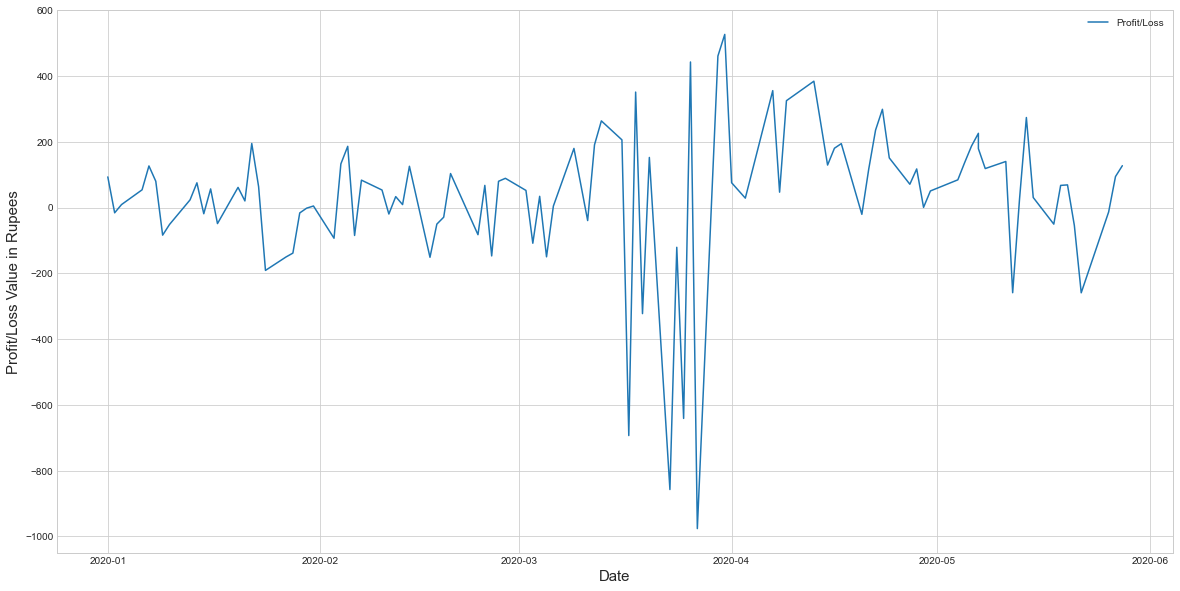

In [67]:
# P/L distribution plot
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(20, 10))
ax = plt.axes()

plt.plot(Straddle_Result['Date'], Straddle_Result['Profit/Loss'])
plt.xlabel('Date',fontsize=15)
plt.ylabel('Profit/Loss Value in Rupees',fontsize=15)
plt.legend(['Profit/Loss'])
plt.show()